In [220]:
import regex as re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm, skew, probplot
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [132]:
Orders = pd.read_csv('data/Orders.csv')
Returns = pd.read_csv('data/Returns.csv')

In [134]:
print(Orders.shape)
Returns.shape

(51290, 24)


(1079, 3)

In [136]:
Orders.head()

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,$221.98,2,0.0,$62.15,40.77,High
1,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","$3,709.40",9,0.1,-$288.77,923.63,Critical
2,25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID","$5,175.17",9,0.1,$919.97,915.49,Medium
3,13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless","$2,892.51",5,0.1,-$96.54,910.16,Medium
4,47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed","$2,832.96",8,0.0,$311.52,903.04,Critical


In [137]:
Returns.head()

,Returned,Order ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania


In [138]:
Orders['Profit'] = Orders['Profit'].map(lambda x: x.replace('$', ''))
Orders['Profit'] = Orders['Profit'].map(lambda x: x.replace(',', ''))
Orders['Profit'] = pd.to_numeric(Orders['Profit'])


In [139]:
Orders['Sales'] = Orders['Sales'].map(lambda x: x.replace('$', ''))
Orders['Sales'] = Orders['Sales'].map(lambda x: x.replace(',', ''))
Orders['Sales'] = pd.to_numeric(Orders['Sales'])


In [140]:
Orders['Month'] = Orders['Order.Date'].map(lambda x: x.split('/')[0])


In [141]:
Orders['Year'] = Orders['Order.Date'].map(lambda x: x.split('/')[2])

In [142]:
Orders['Month'].unique()

array(['11', '2', '10', '1', '6', '4', '3', '12', '7', '9', '8', '5'],
      dtype=object)

<AxesSubplot:xlabel='Month'>

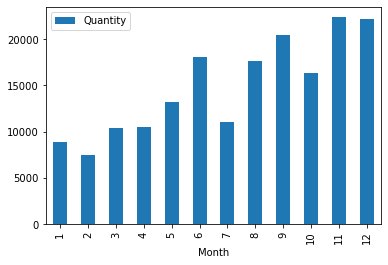

In [143]:
Orders['Month'] = pd.to_numeric(Orders['Month'])
Orders['Year'] = pd.to_numeric(Orders['Year'])
Orders_Monthly = Orders.groupby(by='Month').sum('Quantity').reset_index()
Orders_Monthly.plot(kind = 'bar', x = 'Month', y= 'Quantity')


In [144]:
Orders2 = Orders.groupby(by=['Month','Category']).sum('Quantity')
Orders2 = Orders2['Quantity'].reset_index()

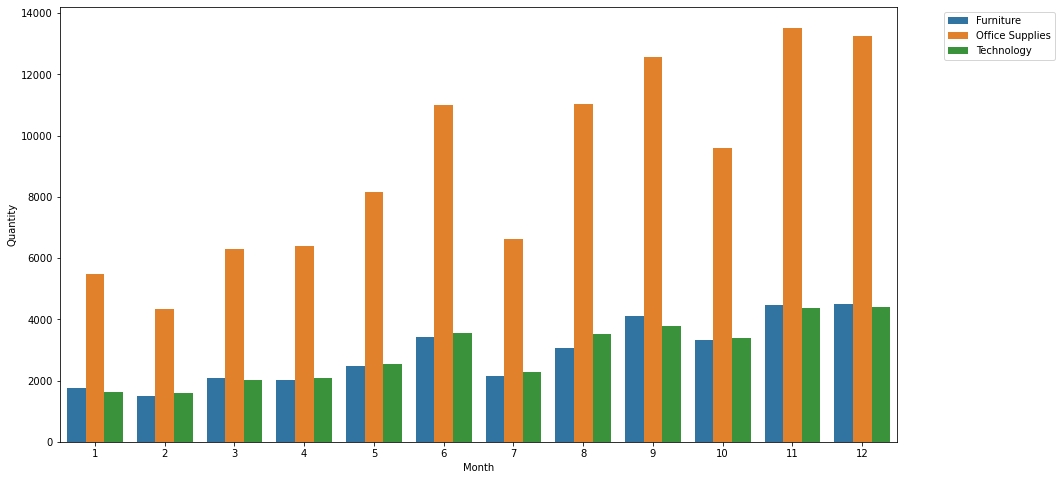

In [145]:
plt.figure(figsize=(15,8))
plot1 = sns.barplot(x='Month', y='Quantity', hue='Category', data = Orders2)
plot1.legend(bbox_to_anchor=(1.05, 1), loc=2)


In [146]:
print(Orders.columns)
Returns.columns


Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority', 'Month', 'Year'],
      dtype='object')


Index(['Returned', 'Order ID', 'Region'], dtype='object')

In [147]:
Orders = Orders.merge(Returns, how = 'left', left_on = 'Order.ID', right_on = 'Order ID')
Orders

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,Month,Year,Returned,Order ID,Region_y
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,2,0.0,62.15,40.770,High,11,14,NaN,NaN,NaN
1,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,9,0.1,-288.77,923.630,Critical,2,14,NaN,NaN,NaN
2,25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,9,0.1,919.97,915.490,Medium,10,14,NaN,NaN,NaN
3,13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,5,0.1,-96.54,910.160,Medium,1,14,NaN,NaN,NaN
4,47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,8,0.0,311.52,903.040,Critical,11,14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,29002,IN-2015-KE1642066-42174,6/19/15,6/19/15,Same Day,KE-1642066,Katrina Edelman,Corporate,NaN,Kure,...,5,0.0,4.50,1.010,Medium,6,15,NaN,NaN,NaN
51286,34337,US-2014-ZD21925140-41765,5/6/14,5/10/14,Standard Class,ZD-219251408,Zuschuss Donatelli,Consumer,37421.0,Chattanooga,...,5,0.2,3.34,1.930,High,5,14,NaN,NaN,NaN
51287,31315,CA-2012-ZD21925140-41147,8/26/12,8/31/12,Second Class,ZD-219251404,Zuschuss Donatelli,Consumer,94109.0,San Francisco,...,2,0.0,2.48,1.580,High,8,12,NaN,NaN,NaN
51288,9596,MX-2013-RB1979518-41322,2/17/13,2/21/13,Standard Class,RB-1979518,Ross Baird,Home Office,NaN,Valinhos,...,2,0.0,2.40,1.003,Medium,2,13,NaN,NaN,NaN


<AxesSubplot:xlabel='Year', ylabel='Profit'>

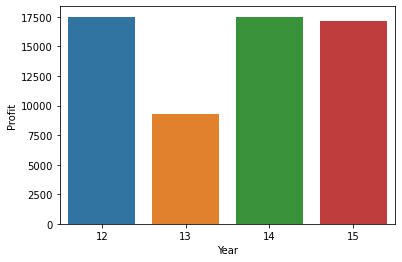

In [148]:
Yes = Orders[Orders['Returned'] == 'Yes']
YY = Yes.groupby(by = 'Year').sum('Profit').reset_index()
sns.barplot(x='Year', y='Profit', data=YY)

In [149]:
YY2 = Yes['Customer.ID'].value_counts()
print((YY2 > 1).sum())
print((YY2 > 5).sum())

547
46


In [150]:
Yes.columns

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region_x', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority', 'Month', 'Year',
       'Returned', 'Order ID', 'Region_y'],
      dtype='object')

In [163]:
YY3 = Orders['Region_x'].value_counts()
YY3 = pd.DataFrame(YY3)
YY3 = YY3.reset_index()
YY3.columns = ['Region', 'Total_Orders']

In [164]:
YY4 = Yes['Region_x'].value_counts()
YY4 = pd.DataFrame(YY4)
YY4 = YY4.reset_index()
YY4.columns = ['Region', 'Total_Returns']

In [166]:
YY4

,Region,Total_Returns
0,Central America,248
1,Western Europe,233
2,Western US,177
3,Oceania,154
4,Southeastern Asia,140
5,Eastern US,134
6,South America,133
7,Eastern Asia,131
8,Southern Europe,112
9,Southern Asia,111


In [167]:
Returns_Region = YY3.merge(YY4, on = 'Region')
Returns_Region

,Region,Total_Orders,Total_Returns
0,Western Europe,5883,233
1,Central America,5616,248
2,Oceania,3487,154
3,Western US,3203,177
4,Southeastern Asia,3129,140
5,South America,2988,133
6,Eastern US,2848,134
7,Southern Asia,2655,111
8,Western Asia,2440,108
9,Eastern Asia,2374,131


In [168]:
Returns_Region['Return_Ratio'] = Returns_Region['Total_Returns'] / Returns_Region['Total_Orders']

<AxesSubplot:xlabel='Region', ylabel='Return_Ratio'>

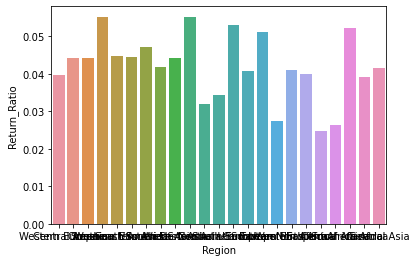

In [169]:
sns.barplot(data=Returns_Region, x='Region', y='Return_Ratio')

In [170]:
YY5 = Orders['Sub.Category'].value_counts()
YY5 = pd.DataFrame(YY5)
YY5 = YY5.reset_index()
YY5.columns = ['Sub.Category', 'Total_Orders']

In [171]:
YY6 = Yes['Sub.Category'].value_counts()
YY6 = pd.DataFrame(YY6)
YY6 = YY6.reset_index()
YY6.columns = ['Sub.Category', 'Total_Returns']

In [173]:
Returns_Category = YY5.merge(YY6, on = 'Sub.Category')
Returns_Category

,Sub.Category,Total_Orders,Total_Returns
0,Binders,6146,269
1,Storage,5049,212
2,Art,4864,217
3,Paper,3492,150
4,Chairs,3434,147
5,Phones,3357,145
6,Furnishings,3154,135
7,Accessories,3075,138
8,Labels,2601,137
9,Fasteners,2601,102


In [174]:
Returns_Category['Return_Ratio'] = Returns_Category['Total_Returns'] / Returns_Category['Total_Orders']

<AxesSubplot:xlabel='Return_Ratio', ylabel='Sub.Category'>

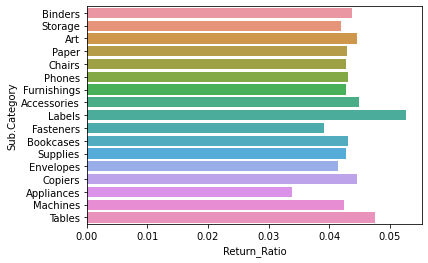

In [176]:
sns.barplot(data=Returns_Category, y='Sub.Category', x='Return_Ratio')

In [178]:
Orders['Returned'].unique()

array([nan, 'Yes'], dtype=object)

# Part II

In [183]:
YN = {'Yes': 1}
Orders['Returned'] = Orders['Returned'].map(YN)
Orders['Returned'].sum()

2220.0

In [184]:
Orders['Returned'] = Orders['Returned'].fillna(0)

In [185]:
Orders['Returned'].value_counts()

0.0    49070
1.0     2220
Name: Returned, dtype: int64

In [186]:
Orders.columns

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region_x', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority', 'Month', 'Year',
       'Returned', 'Order ID', 'Region_y'],
      dtype='object')

In [189]:
Orders['Ship.Date'] = pd.to_datetime(Orders['Ship.Date'])

In [190]:
Orders['Order.Date'] = pd.to_datetime(Orders['Order.Date'])

In [192]:
Orders['Process_Time'] = Orders['Ship.Date'] - Orders['Order.Date']
Orders

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Discount,Profit,Shipping.Cost,Order.Priority,Month,Year,Returned,Order ID,Region_y,Process_Time
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,0.0,62.15,40.770,High,11,14,0.0,NaN,NaN,2 days
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,0.1,-288.77,923.630,Critical,2,14,0.0,NaN,NaN,2 days
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,0.1,919.97,915.490,Medium,10,14,0.0,NaN,NaN,1 days
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,0.1,-96.54,910.160,Medium,1,14,0.0,NaN,NaN,2 days
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,0.0,311.52,903.040,Critical,11,14,0.0,NaN,NaN,1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,29002,IN-2015-KE1642066-42174,2015-06-19,2015-06-19,Same Day,KE-1642066,Katrina Edelman,Corporate,NaN,Kure,...,0.0,4.50,1.010,Medium,6,15,0.0,NaN,NaN,0 days
51286,34337,US-2014-ZD21925140-41765,2014-05-06,2014-05-10,Standard Class,ZD-219251408,Zuschuss Donatelli,Consumer,37421.0,Chattanooga,...,0.2,3.34,1.930,High,5,14,0.0,NaN,NaN,4 days
51287,31315,CA-2012-ZD21925140-41147,2012-08-26,2012-08-31,Second Class,ZD-219251404,Zuschuss Donatelli,Consumer,94109.0,San Francisco,...,0.0,2.48,1.580,High,8,12,0.0,NaN,NaN,5 days
51288,9596,MX-2013-RB1979518-41322,2013-02-17,2013-02-21,Standard Class,RB-1979518,Ross Baird,Home Office,NaN,Valinhos,...,0.0,2.40,1.003,Medium,2,13,0.0,NaN,NaN,4 days


In [193]:
Orders.columns

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region_x', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority', 'Month', 'Year',
       'Returned', 'Order ID', 'Region_y', 'Process_Time'],
      dtype='object')

In [198]:
Product_Returns = Orders.groupby(by='Product.ID').sum('Returned')
Product_Returns = Product_Returns.reset_index()
Product_Returns

,Product.ID,Row.ID,Postal.Code,Sales,Quantity,Discount,Profit,Shipping.Cost,Month,Year,Returned
0,FUR-BO-3174,67842,158643.0,400.02,3,1.02,-113.26,41.54,14,29,0.0
1,FUR-BO-3175,272057,322155.0,7539.71,35,1.47,780.32,1009.83,68,107,0.0
2,FUR-BO-3176,213409,300983.0,5184.10,27,1.60,-126.43,743.43,62,80,1.0
3,FUR-BO-3177,302789,501091.0,5492.89,26,2.53,15.05,545.53,49,114,0.0
4,FUR-BO-3409,282697,565118.0,1897.81,31,2.52,-612.93,193.24,68,108,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3783,TEC-PH-6365,377975,668183.0,8878.40,32,2.20,515.52,810.45,76,139,1.0
3784,TEC-PH-6413,216179,198253.0,5327.26,17,1.00,1043.87,632.50,51,81,1.0
3785,TEC-PH-6425,258331,329156.0,4044.39,24,1.00,733.28,422.95,50,93,1.0
3786,TEC-PH-6427,65437,86117.0,604.75,5,0.20,132.29,54.34,16,25,0.0


In [200]:
Orders = Orders.merge(Product_Returns, how = 'left', on = 'Product.ID')
Orders

,Row.ID_x,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code_x,City,...,Row.ID_y,Postal.Code_y,Sales_y,Quantity_y,Discount_y,Profit_y,Shipping.Cost_y,Month_y,Year_y,Returned_y
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,76481,92240.0,688.14,9,0.400,-31.08,73.750,14,27,0.0
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,452017,0.0,28629.52,80,2.910,2291.20,3381.278,173,340,2.0
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,566017,0.0,47877.80,96,3.540,9465.34,5321.110,206,325,2.0
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,675788,0.0,38931.04,74,2.720,-4447.04,3774.300,191,311,0.0
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,270866,0.0,16026.77,51,1.174,2109.35,2061.225,105,171,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,29002,IN-2015-KE1642066-42174,2015-06-19,2015-06-19,Same Day,KE-1642066,Katrina Edelman,Corporate,NaN,Kure,...,465031,0.0,622.06,66,3.410,-50.90,75.014,153,254,1.0
51286,34337,US-2014-ZD21925140-41765,2014-05-06,2014-05-10,Standard Class,ZD-219251408,Zuschuss Donatelli,Consumer,37421.0,Chattanooga,...,280510,589252.0,111.19,31,1.000,28.24,12.430,84,111,0.0
51287,31315,CA-2012-ZD21925140-41147,2012-08-26,2012-08-31,Second Class,ZD-219251404,Zuschuss Donatelli,Consumer,94109.0,San Francisco,...,246298,295762.0,96.73,23,0.200,26.83,19.770,50,94,0.0
51288,9596,MX-2013-RB1979518-41322,2013-02-17,2013-02-21,Standard Class,RB-1979518,Ross Baird,Home Office,NaN,Valinhos,...,876789,0.0,1010.76,120,2.520,338.88,121.495,301,498,2.0


In [201]:
Orders.columns

Index(['Row.ID_x', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code_x', 'City',
       'State', 'Country', 'Region_x', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales_x', 'Quantity_x', 'Discount_x',
       'Profit_x', 'Shipping.Cost_x', 'Order.Priority', 'Month_x', 'Year_x',
       'Returned_x', 'Order ID', 'Region_y', 'Process_Time', 'Row.ID_y',
       'Postal.Code_y', 'Sales_y', 'Quantity_y', 'Discount_y', 'Profit_y',
       'Shipping.Cost_y', 'Month_y', 'Year_y', 'Returned_y'],
      dtype='object')

In [202]:
Orders = Orders.drop(['Region_y', 'Row.ID_y',
       'Postal.Code_y', 'Sales_y', 'Quantity_y', 'Discount_y', 'Profit_y',
       'Shipping.Cost_y', 'Month_y', 'Year_y'], axis = 1)

In [204]:
Orders = Orders.rename(columns = {'Returned_y': 'Prod_Returns'})

In [205]:
Orders

,Row.ID_x,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code_x,City,...,Discount_x,Profit_x,Shipping.Cost_x,Order.Priority,Month_x,Year_x,Returned_x,Order ID,Process_Time,Prod_Returns
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,0.0,62.15,40.770,High,11,14,0.0,NaN,2 days,0.0
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,0.1,-288.77,923.630,Critical,2,14,0.0,NaN,2 days,2.0
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,0.1,919.97,915.490,Medium,10,14,0.0,NaN,1 days,2.0
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,0.1,-96.54,910.160,Medium,1,14,0.0,NaN,2 days,0.0
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,0.0,311.52,903.040,Critical,11,14,0.0,NaN,1 days,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,29002,IN-2015-KE1642066-42174,2015-06-19,2015-06-19,Same Day,KE-1642066,Katrina Edelman,Corporate,NaN,Kure,...,0.0,4.50,1.010,Medium,6,15,0.0,NaN,0 days,1.0
51286,34337,US-2014-ZD21925140-41765,2014-05-06,2014-05-10,Standard Class,ZD-219251408,Zuschuss Donatelli,Consumer,37421.0,Chattanooga,...,0.2,3.34,1.930,High,5,14,0.0,NaN,4 days,0.0
51287,31315,CA-2012-ZD21925140-41147,2012-08-26,2012-08-31,Second Class,ZD-219251404,Zuschuss Donatelli,Consumer,94109.0,San Francisco,...,0.0,2.48,1.580,High,8,12,0.0,NaN,5 days,0.0
51288,9596,MX-2013-RB1979518-41322,2013-02-17,2013-02-21,Standard Class,RB-1979518,Ross Baird,Home Office,NaN,Valinhos,...,0.0,2.40,1.003,Medium,2,13,0.0,NaN,4 days,2.0


In [252]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [207]:
Y = Orders['Returned_x']

In [208]:
Orders.columns

Index(['Row.ID_x', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code_x', 'City',
       'State', 'Country', 'Region_x', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales_x', 'Quantity_x', 'Discount_x',
       'Profit_x', 'Shipping.Cost_x', 'Order.Priority', 'Month_x', 'Year_x',
       'Returned_x', 'Order ID', 'Process_Time', 'Prod_Returns'],
      dtype='object')

In [232]:
X = Orders[['Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.Name', 'Segment', 'Postal.Code_x', 'City',
       'State', 'Country', 'Region_x', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales_x', 'Quantity_x', 'Discount_x',
       'Profit_x', 'Shipping.Cost_x', 'Order.Priority', 'Month_x', 'Year_x',
       'Process_Time', 'Prod_Returns']]

In [233]:

X1 = pd.get_dummies(X[['Ship.Mode',
       'Segment','Region_x', 'Market', 'Category',
       'Sub.Category',
       'Order.Priority',
       'Process_Time']])
X1.columns

Index(['Process_Time', 'Ship.Mode_First Class', 'Ship.Mode_Same Day',
       'Ship.Mode_Second Class', 'Ship.Mode_Standard Class',
       'Segment_Consumer', 'Segment_Corporate', 'Segment_Home Office',
       'Region_x_Canada', 'Region_x_Caribbean', 'Region_x_Central Africa',
       'Region_x_Central America', 'Region_x_Central Asia',
       'Region_x_Central US', 'Region_x_Eastern Africa',
       'Region_x_Eastern Asia', 'Region_x_Eastern Europe',
       'Region_x_Eastern US', 'Region_x_North Africa',
       'Region_x_Northern Europe', 'Region_x_Oceania',
       'Region_x_South America', 'Region_x_Southeastern Asia',
       'Region_x_Southern Africa', 'Region_x_Southern Asia',
       'Region_x_Southern Europe', 'Region_x_Southern US',
       'Region_x_Western Africa', 'Region_x_Western Asia',
       'Region_x_Western Europe', 'Region_x_Western US', 'Market_Africa',
       'Market_Asia Pacific', 'Market_Europe', 'Market_LATAM', 'Market_USCA',
       'Category_Furniture', 'Category_Offi

In [242]:
X1['Process_Time'] = X1['Process_Time'].astype(str).map(lambda x: x.split(' ')[0])

In [243]:
X2=X[['Sales_x', 'Quantity_x', 'Discount_x',
       'Profit_x', 'Shipping.Cost_x', 'Month_x', 'Year_x',
       'Prod_Returns']]

X = pd.concat([X1, X2], axis=1)

In [244]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [245]:
X_train

,Process_Time,Ship.Mode_First Class,Ship.Mode_Same Day,Ship.Mode_Second Class,Ship.Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Region_x_Canada,Region_x_Caribbean,...,Order.Priority_Low,Order.Priority_Medium,Sales_x,Quantity_x,Discount_x,Profit_x,Shipping.Cost_x,Month_x,Year_x,Prod_Returns
48142,5,0,0,1,0,0,0,1,0,0,...,0,1,45.84,8,0.0,22.00,3.94,12,15,0.0
46551,4,0,0,0,1,0,1,0,0,0,...,0,0,5.54,7,0.2,1.66,1.72,11,12,0.0
13524,2,0,0,1,0,0,1,0,0,0,...,0,1,255.45,5,0.0,73.95,22.73,10,13,3.0
32461,4,0,0,0,1,0,1,0,0,0,...,0,1,53.08,2,0.1,7.06,4.48,11,15,0.0
23857,5,0,0,1,0,1,0,0,0,0,...,0,1,101.46,2,0.0,32.46,9.01,3,14,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,5,0,0,0,1,1,0,0,0,0,...,0,1,3.98,2,0.6,-2.69,1.05,2,15,1.0
32511,6,0,0,0,1,0,0,1,0,0,...,0,1,53.84,2,0.1,17.90,4.46,8,15,2.0
5192,5,0,0,0,1,0,1,0,0,0,...,0,1,63.94,3,0.2,6.39,4.70,4,13,0.0
12172,2,1,0,0,0,1,0,0,0,0,...,0,0,289.80,7,0.2,36.23,75.76,7,13,0.0


In [251]:
rfc = RandomForestClassifier(bootstrap=True, n_estimators=100, oob_score=True)
params = {"min_samples_leaf": 4, "min_samples_split": 4}
rfc.set_params = params
rfc.fit(X_train, Y_train)
print(rfc.score(X_train, Y_train))
Predict = rfc.predict(X_train)
RMSE = np.sqrt(mean_squared_error(Y_train, Predict))
print(RMSE)
print(rfc.oob_score_)

0.9999756287775394
0.004936721833415229
0.9573259894716319


In [253]:
print(rfc.score(X_test, Y_test))
Predict = rfc.predict(X_test)
RMSE = np.sqrt(mean_squared_error(Y_test, Predict))
print(RMSE)

0.9557418600116981
0.2103761868375359
